In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# import fitter
from HMC import HMC
import sys
sys.path.append("..")
from MCMC_DianZhang.Dian_BayesianInference.Dian_BayesianInference.MultiGaussianLikeli import Likelihood_MultidimensionalGaussian

### Data and visualization
With extension to `MCMC_DianZhang/test.ipynb`.

Visualise the distribution $N(\left( \begin{array}{c} 0 \\ 0 \end{array}\right),\left( \begin{array}{cc} 2.5 & 0.5 \\ 0.5 & 2 \end{array}\right))$.  

In [3]:
mean = [0, 0]
cov = [[2.5, 0.5], [0.5, 2]]
rv = multivariate_normal(mean=mean, cov=cov)
dataset = np.random.multivariate_normal(mean,cov,100)

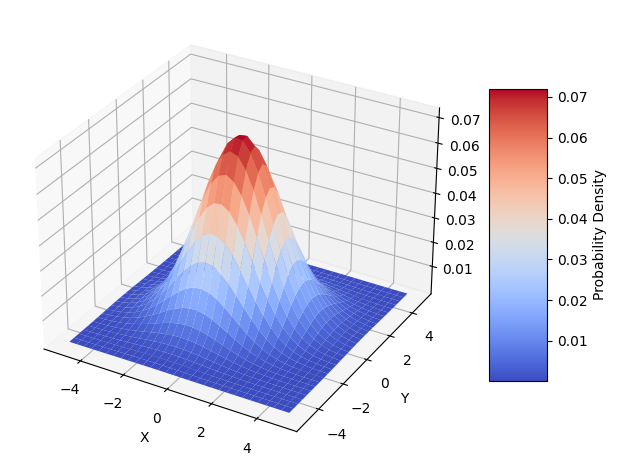

In [4]:
# number of points (30, 30)
X, Y = np.mgrid[-5.:5.:30j, -5.:5.:30j]

# Need an (N, 2) array of (x, y) pairs
DATA = np.dstack((X.flat, Y.flat))
Z = rv.pdf(DATA)
# reshape back to a (30, 30) grid
Z = Z.reshape(X.shape)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.set_zlabel('Probability Density')
surf = ax.plot_surface(X,Y,Z,cmap='coolwarm')
#wire = ax.plot_wireframe(X,Y,Z,cmap='coolwarm')

fig.colorbar(surf, shrink=0.65,aspect=5,label='Probability Density')
plt.tight_layout()
plt.show()

C:\Users\jq822\AppData\Local\Temp\ipykernel_20212\1480310642.py:5: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(X, Y, Z, level=15, cmap='Blues')


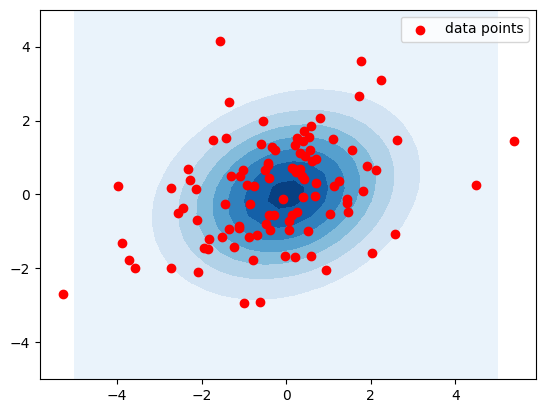

In [5]:
X, Y = np.mgrid[-5.:5.:30j, -5.:5.:30j]
DATA = np.dstack((X, Y))
Z = rv.pdf(DATA)

plt.contourf(X, Y, Z, level=15, cmap='Blues')
plt.scatter(dataset[:,0],dataset[:,1],label='data points',color='red')
plt.legend()
plt.show()

### Likelihood for a 2D Gaus

In [6]:
Likeli = Likelihood_MultidimensionalGaussian(Dim=2, Sigma=cov, Dataset=dataset)

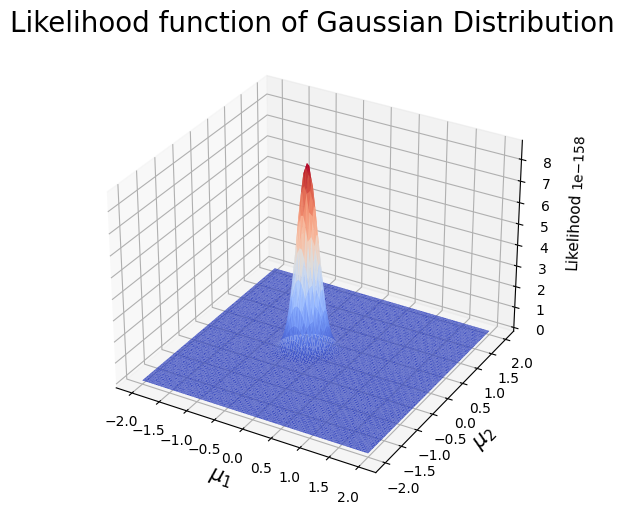

In [7]:
Grid = np.linspace(-2, 2, 100)
x = []
y = []
z = []
r = len(Grid)

for g in Grid:
    y += list(Grid+mean[1])
    x += [g+mean[0]]*r
    z += [Likeli.L([g+mean[0], k+mean[1]]) for k in Grid]
# x, y, z = np.array(x), np.array(y), np.array(z)
# z = z.reshape((100,100))

fig = plt.figure(figsize=(10,6),facecolor="white")

Gau = fig.add_subplot(projection="3d")
Gau.plot_trisurf(x, y, z, cmap='coolwarm')
Gau.set_xlabel("$\mu_1$", fontsize=15)
Gau.set_ylabel("$\mu_2$", fontsize=15)
Gau.set_zlabel("Likelihood", fontsize=11)
Gau.set_title("Likelihood function of Gaussian Distribution", fontsize=20)

plt.show()

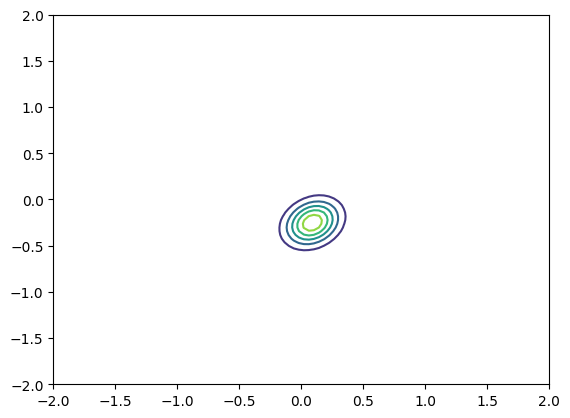

In [8]:
x_, y_ = list(Grid+mean[0]), list(Grid+mean[1])
z_ = np.array(z)
z_ = z_.reshape((len(x_),len(y_)))
plt.contour(x_,y_,z_)

#### using `numpyro`

In [97]:
from numpyro import distributions

target_dist = distributions.MultivariateNormal(
    np.array([0, 0]), np.array([[2.5, 0.5], 
                           [0.5, 2]]))

def target_log_prob_fn(state):
    return target_dist.log_prob(state)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


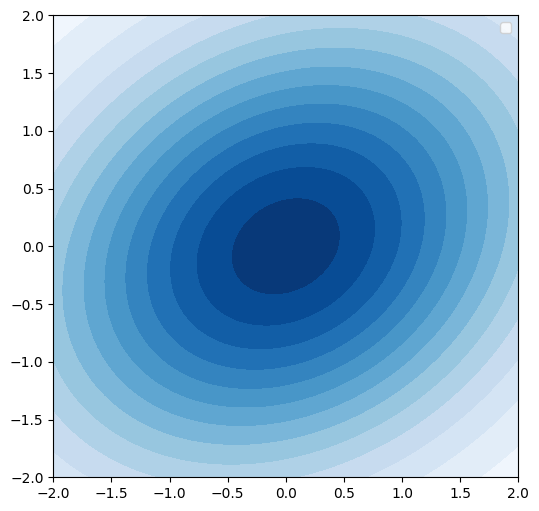

In [100]:
X, Y = np.meshgrid(np.linspace(-2, 2, 100), 
                   np.linspace(-2, 2, 100), 
                  )

_X = np.stack([X, Y]).reshape(2, -1)
probs = np.exp(target_log_prob_fn(_X.T).reshape((100, 100)))

fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(
    X, Y,
    probs, 
    levels=15,
    cmap='Blues'
)

ax.legend()

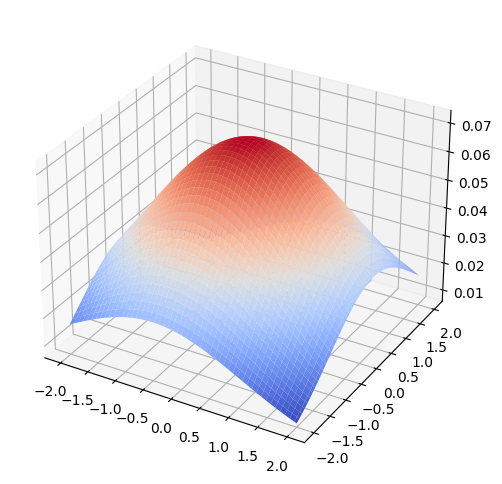

In [84]:
fig = plt.figure(figsize=(10,6),facecolor="white")

ax = fig.add_subplot(projection="3d")
ax.plot_surface(X,Y,probs,cmap='coolwarm')

### Likelihood for MultiGaus

**Info in the link [How to evaluate the multivariate normal log likelihood](https://blogs.sas.com/content/iml/2020/07/15/multivariate-normal-log-likelihood.html#:~:text=The%20log%2Dlikelihood%20for%20a,also%20called%20a%20log%2DPDF.)**

The log-likelihood for a vector $\mathbf{x}$ is the natural logarithm of the **multivariate normal (MVN)** density function evaluated at $\mathbf{x}$. A probability density function is usually abbreviated as PDF, so the log-density function is also called a log-PDF.

**The multivariate normal PDF**

The multivariate normal distribution in dimension $d$ has two parameters: A d-dimensional mean vector $\bm{\mu}$ and a $d \times d$ covariance matrix $\mathbf{\Sigma}$. The MVN PDF evaluated at a d-dimensional vector $\mathbf{x}$ is

$f(\mathbf{x}) = \frac{1}{\sqrt{(2\pi)^{d}|\mathbf{\Sigma}|}} exp(-\frac{1}{2}(\mathbf{x}-\bm{\mu})^{T} \bm{\Sigma}^{-1} (\mathbf{x} - \bm{\mu}))$

where $\bm{\Sigma}$ is the determinant of $\bm{\Sigma}$.

**Evaluate the MVN log-likelihood function**

$\log (f(\mathbf{x})) = -\frac{1}{2}[d \log (2 \pi) + log (|\bm{\Sigma}|) + MD(\mathbf{x}; \bm{\mu}, \bm{\Sigma})^{2}]$

where $MD$ is the Mahalanobis distance between the point $\mathbf{x}$ and the mean vector $\bm{\mu}$.

In [51]:
mean = [0, 0, 2, 2]
cov = [[1., 4., 3., 2.], 
        [4., 1., 1., 1.], 
        [3., 1., 1., 2.], 
        [2., 1., 2., 1.]]
rv = multivariate_normal(mean=mean, cov=cov)
dataset = np.random.multivariate_normal(mean,cov,100)

ValueError: The input matrix must be symmetric positive semidefinite.

In [19]:
Likeli = Likelihood_MultidimensionalGaussian(Dim=4, Sigma=cov, Dataset=dataset)

In [22]:
Dataset = []
for _ in range(0,100):
    Dataset.append(list(np.random.default_rng().multivariate_normal(mean, cov, 1)[0]))

In [122]:
from numpyro import distributions

mean = [1, 1], [5, 5]
cov = [[1, 0], [0, 1]], [[2, 0], [0, 2]]

target_dist = distributions.MultivariateNormal(
    np.array(mean), np.array(cov))

def target_log_prob_fn(state):
    return target_dist.log_prob(state)

In [ ]:
X1, Y1 = np.meshgrid(np.linspace(-1, 3, 100), 
                   np.linspace(-1, 3, 100), 
                  )

X2, Y2 = np.meshgrid(np.linspace(0, 10, 100), 
                   np.linspace(0, 10, 100), 
                  )

_X1 = np.stack([X1, Y1]).reshape(2, -1)
_X2 = np.stack([X2, Y2]).reshape(2, -1)
probs = np.exp(target_log_prob_fn(np.dstack((_X1.T,_X2.T))))


fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X1,Y1,probs[:,0].reshape(100,100))

# ax.contourf(
#     X1, Y1,
#     probs1, 
#     levels=15,
#     cmap='Blues'
# )

ax.legend()

### HMC

In [21]:
from typing import List

def U(theta: List[float]) -> float: # the potential energy function: U(theta) = -log(probability distribution of theta)
    return (- np.log(Likeli.L(theta)))

def grad_U(theta: List[float]) -> float:
    DRho = Likeli.dLdmu(theta)
    Rho = Likeli.L(theta)*(-1)
    return np.array([DRho/Rho for DRho in DRho])

In [ ]:
theta_accept, theta_reject = HMC(epoch=2000, L=20, epsilon=0.001, U=U, grad_U=grad_U, current_theta=np.array([1, 1, 1, 1]))

In [36]:
mu = np.array([1,1,1,1])

In [32]:
Dataset[0]

[0.9498922995116301, 0.9844477116766173, 3.30812541414702, 1.0644860262219114]

In [49]:
Dataset-mu

array([[-0.0501077 , -0.01555229,  2.30812541,  0.06448603],
       [-1.75089013, -1.84961724,  0.09436502,  0.6269643 ],
       [-1.9233533 , -2.18464998, -0.63984473,  1.36983343],
       [ 0.78258697, -0.2823409 ,  2.33412535, -0.1908415 ],
       [-1.00340183, -0.88990375,  0.51135557,  1.51624786],
       [-0.68385799, -1.61907463, -0.10449763,  0.62167408],
       [-0.72104503, -0.87874899,  0.04164737,  1.58563094],
       [-0.62287992, -1.20535934,  2.18062932, -0.18731353],
       [-0.82660793, -0.27486695,  0.58623549,  0.86813435],
       [-0.21811551, -1.42327645, -0.66358592,  1.57761571],
       [-1.90229767, -2.32131125, -0.06097665,  0.93904336],
       [-0.18077581, -1.45637873,  3.35686384,  1.02702201],
       [-1.93572957, -1.58539284,  1.88563072,  1.94760792],
       [ 0.29033489, -0.12177198,  1.58951312,  1.11257759],
       [-0.99773776, -1.3400155 , -1.21166301,  1.1484865 ],
       [-1.0088782 , -2.34112655,  2.33807798,  2.48866351],
       [-1.13302396, -0.

In [41]:
res *= ((2*np.pi)**(-2))*(np.linalg.det(cov)**(-1/2))*np.exp(-((Dataset[0]-mu)@np.linalg.inv(cov)@(Dataset[0]-mu).T)/2)

In [47]:
Likeli.L(mu)

0.0